<a href="https://colab.research.google.com/github/Vetselet/Task_sphere_NN/blob/main/Norm_Baseline_NN_sphere_mass_10_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
# from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
%pylab inline
import warnings
from scipy import stats
from scipy.integrate import quad
import plotly.express as px
from scipy import stats
from scipy import interpolate
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15
from google.colab import drive

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
# plt.rcParams['xtick.minor.visible'] = 'True'

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams.update({'font.size':20})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mp=1.001
mHe=4.0026
mN=14.007
mS=32.064
mFe=55.845
m=np.array([mp,mHe,mN,mS,mFe])
ln_m=np.log(m)

import random
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(30)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
ln_m

array([9.99500333e-04, 1.38694415e+00, 2.63955720e+00, 3.46773391e+00,
       4.02258000e+00])

# Функции

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="upper right")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)


def get_correct_count(pred, labels):
  # _, predicted = torch.max(pred.data, 1)
  predicted,indices= torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        video,imgs, labels = batch
        video=video.to(device)
        imgs=imgs.to(device)
        labels=labels.to(device)
        batch_size_acc=len(labels)
        pred = model(video,imgs,batch_size_acc)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

def calaculate_mae(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    val_mae=0
    for batch in data_loader:
        video,imgs, labels = batch
        video=video.to(device)
        imgs=imgs.to(device)
        labels=labels.to(device)
        batch_size_acc=len(labels)
        pred = model(video,imgs,batch_size_acc)
        loss += criterion(pred, labels)
        # correct += get_correct_count(pred,labels)
        mae_loss=nn.L1Loss()
        epoch_mae=mae_loss(pred, labels)/batch_size_acc
        val_mae+=epoch_mae
        # correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return val_mae/ len(data_loader)    , loss.item() / len(data_loader)

# Загрузка данных

In [ ]:
from ast import Pass
drive.mount('/content/drive')
direct_q1='drive/MyDrive/data_sphere/data_to_NN_q1_900_10PeV_10-20/'
direct_q2='drive/MyDrive/data_sphere/data_to_NN_q2_900_10PeV_10-20/'

data_direct=[direct_q1+'glob_array_p_q1.npy',direct_q1+'glob_array_He_q1.npy',direct_q1+'glob_array_N_q1.npy',direct_q1+'glob_array_S_q1.npy',direct_q1+'glob_array_Fe_q1.npy',\
             direct_q2+'glob_array_p_q2.npy',direct_q2+'glob_array_He_q2.npy',direct_q2+'glob_array_N_q2.npy',direct_q2+'glob_array_S_q2.npy',direct_q2+'glob_array_Fe_q2.npy']
map_direct=[direct_q1+'map2_p_q1.npy',direct_q1+'map2_He_q1.npy',direct_q1+'map2_N_q1.npy',direct_q1+'map2_S_q1.npy',direct_q1+'map2_Fe_q1.npy',\
             direct_q2+'map2_p_q2.npy',direct_q2+'map2_He_q2.npy',direct_q2+'map2_N_q2.npy',direct_q2+'map2_S_q2.npy',direct_q2+'map2_Fe_q2.npy']

border=1200   # граница числа фотонов, если их в сумме зарегистрировалось меньше в одном событии, то такое событие не рассматривается.
data_all,data_2D,data_y=[],[],[]
# target_num=[0,1,1,0,1,1]
target_num=[0,1,2,3,4,0,1,2,3,4]

target_mass=[ln_m[0],ln_m[1],ln_m[2],ln_m[3],ln_m[4],ln_m[0],ln_m[1],ln_m[2],ln_m[3],ln_m[4]]
for i in range(10):

    particle_data=np.load( data_direct[i])
    particle_data=particle_data.reshape(6000,1,50,11,11)

    # Обрезаем данные
    bool_mask=[sum(particle_data[i])<border for i in range(6000)]
    particle_data=particle_data[~np.array(bool_mask)]
    # print(particle_data.min() ,particle_data.max())

    map2D=np.load( map_direct[i])
    map2D=map2D.reshape(6000,2,11,11)
    map2D=map2D[~np.array(bool_mask)]
    # print(map2D.min(),map2D.max())

    data_all.append(particle_data)
    data_2D.append(map2D)
    # data_y.append([target_num[i]]*particle_data.shape[0])    # В качетсве y целые числа, 0, 1, 2
    data_y.append([target_mass[i]]*particle_data.shape[0])

    print(particle_data.shape)


if len(data_all)==10:
    data_video=np.concatenate([data_all[0],data_all[1],data_all[2],data_all[3],data_all[4],data_all[5],data_all[6],data_all[7],data_all[8],data_all[9]])
    data_map = np.concatenate([data_2D[0],data_2D[1],data_2D[2],data_2D[3],data_2D[4],data_2D[5],data_2D[6],data_2D[7],data_2D[8],data_2D[9]])
    data_y=np.concatenate([data_y[0],data_y[1],data_y[2],data_y[3],data_y[4],data_y[5],data_y[6],data_y[7],data_y[8],data_y[9]])
    print('data video = ',data_video.shape,',  data map = ',data_map.shape,',  data y = ',data_y.shape)

data_video=(data_video-data_video.min())/(data_video.max()-data_video.min())   # Нормализция данных по кол-ву фотонов в ФЭУ в видео

Mounted at /content/drive
(4271, 1, 50, 11, 11)
(3977, 1, 50, 11, 11)
(3643, 1, 50, 11, 11)
(3481, 1, 50, 11, 11)
(3213, 1, 50, 11, 11)
(4261, 1, 50, 11, 11)
(4045, 1, 50, 11, 11)
(3701, 1, 50, 11, 11)
(3502, 1, 50, 11, 11)
(3235, 1, 50, 11, 11)
data video =  (37329, 1, 50, 11, 11) ,  data map =  (37329, 2, 11, 11) ,  data y =  (37329,)


data_video[0][0] -- это для одного события

data_map -- [sum_signal, time]

## Нормализация числа фотонов по каждому событию

In [ ]:
# Нормировка видео в каждом событии по максимуму
video_norm_each=np.array([data_video[i][0]/data_video[i][0].max() for i in range(data_video.shape[0])])

In [ ]:
# Нормировка карты суммарных сигналов в каждом событии по максимуму
map_0_norm_each=[data_map[i][0]/data_map[i][0].max() for i in range(data_map.shape[0])]
map_time=[data_map[i][1] for i in range(data_map.shape[0])]
maps_norm=np.array(list(zip(map_0_norm_each,map_time)))
# Нормировка карты времени общая по всем событиям
maps_norm[:,1]=(maps_norm[:,1]-maps_norm[:,1].min())/(maps_norm[:,1].max()-maps_norm[:,1].min())

## Стандартизация

In [ ]:
# Стандартизация карт
m=(data_map[:,0]-data_map[:,0].mean())/data_map[:,0].std()  # Стандартизация числа фотонов
t=(data_map[:,1]-data_map[:,1].mean())/data_map[:,1].std()  # Стандартизация времени
a=np.array(list(zip(m,t)))
a.shape

(37329, 2, 11, 11)

In [ ]:
# Стандартизация видеоряда
vid=data_video.reshape(data_video.shape[0],50,11,11)
v=(vid-vid.mean())/vid.std()
v.shape

(37329, 50, 11, 11)

# Введение X и y

In [ ]:
X= video_norm_each
X = X.reshape(X.shape[0], 1, 50, 11, 11)
print( 'X shape = ', X.shape)

y=data_y.reshape(data_y.shape[0],1)
print( 'y shape = ', y.shape)

X_concat=np.array(list(zip(X,maps_norm)))

print(X_concat.shape)
print(X_concat[0,0].shape)
print(X_concat[0,1].shape)

X shape =  (37329, 1, 50, 11, 11)
y shape =  (37329, 1)
(37329, 2)
(1, 50, 11, 11)
(2, 11, 11)


In [ ]:
# Для стандартизованных данных

X= v
X = X.reshape(X.shape[0], 1, 50, 11, 11)
print( 'X shape = ', X.shape)

y=data_y.reshape(data_y.shape[0],1)
print( 'y shape = ', y.shape)

X_concat=np.array(list(zip(X,a)))

print(X_concat.shape)
print(X_concat[0,0].shape)
print(X_concat[0,1].shape)

X shape =  (37329, 1, 50, 11, 11)
y shape =  (37329, 1)
(37329, 2)
(1, 50, 11, 11)
(2, 11, 11)


# Разделение на обучающую и треничровачную выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y, test_size=0.35, stratify = y, random_state=30, shuffle=True)

In [ ]:
uniq,counts=np.unique(y_test,return_counts=True)
dict(zip(uniq,counts))

{0.0009995003330834232: 2986,
 1.3869441499613877: 2808,
 2.6395572046569096: 2571,
 3.4677339054623997: 2444,
 4.02257999599279: 2257}

In [ ]:
df_y=pd.DataFrame({'y':y_test.reshape(-1)})

mass_value =ln_m

df_y['m_name']=0
df_y['m_name'][df_y['y']==mass_value[0]]='p'
df_y['m_name'][df_y['y']==mass_value[1]]='He'
df_y['m_name'][df_y['y']==mass_value[2]]='N'
df_y['m_name'][df_y['y']==mass_value[3]]='S'
df_y['m_name'][df_y['y']==mass_value[4]]='Fe'
df_y

,y,m_name
0,1.386944,He
1,3.467734,S
2,2.639557,N
3,1.386944,He
4,2.639557,N
...,...,...
13061,2.639557,N
13062,0.001000,p
13063,3.467734,S
13064,2.639557,N


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X,y):

        self.X = X[:,0]
        self.map=X[:,1]
        self.y=y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        video = torch.tensor(np.float32(self.X[idx]))
        imgs = torch.tensor(np.float32(self.map[idx]))
        label=torch.tensor(np.float32(self.y[idx]))

        return video/video.max(), imgs/imgs.max(), label

batch_size=64

X_train_norm=X_train

train_dataset=CustomDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset=CustomDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Архитектура сети

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv3d(1, 32, (2,1,1), stride=(4,1,1), padding=0)
        self.conv2 = nn.Conv3d(32, 16, (2,1,1), stride=(4,1,1), padding=0)
        self.conv3 = nn.Conv3d(16, 8, (3,1,1), stride=(1,1,1), padding=0)

        self.fc1 = nn.Linear(11*11*10, 11*11*4)
        # self.fc1 = nn.Linear(11*11*9, 11*11*4)
        # self.fc1 = nn.Linear(11*11*8, 11*11*4)
        self.fc2 = nn.Linear(11*11*4, 1)


        self.fc1 = nn.Linear(11*11*10, 1)

        # self.fc2 = nn.Linear(11*11*1, 1)

    def forward(self, video,imgs,batch_size_nn=2):
        video = F.relu(self.conv1(video))
        video = F.relu(self.conv2(video))
        video = F.relu(self.conv3(video))
        video = video.view(batch_size_nn,8, 11, 11)
        # x=video

        x = torch.cat((video, imgs), dim=1)      # Получили размерность (10,11,11)
        # x = torch.cat((video, imgs[:,1].reshape(imgs.shape[0],1,11,11)), dim=1)    # Получили размерность (9,11,11)
        # x=imgs[:,0].reshape(imgs.shape[0],1,11,11)       # Получили размерность (1,11,11)
        x = torch.flatten(x,1)

        x= self.fc1(x)
        # x= self.fc2(x)

        return x

# **Цикл обучения.**

In [ ]:
def train(model, criterion, optimizer, num_epochs=5):
    pp = ProgressPlotter()
    mae_loss = nn.L1Loss()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total, ep_loss = 0, 0, 0
        epochs_mae=0
        for i, data in enumerate(train_dataloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          inputs, imgs, labels = data
          inputs=inputs.to(device)
          imgs=imgs.to(device)
          labels=labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          batch_size_nn=len(labels)
          # forward + backward + optimize
          outputs = model(inputs,imgs,batch_size_nn)
          loss = criterion(outputs, labels)
          # correct += get_correct_count(outputs, labels)

          epoch_mae=mae_loss(outputs, labels)/batch_size_nn
          epochs_mae+=epoch_mae
          # print(epoch_mae)

          loss.backward()

          if optimizer.param_groups[0]["lr"] < 10e-7: # if learning step becomes too small
              print(epoch)
              break

          # scheduler.step(loss)
          optimizer.step()

          total += labels.size(0)
          ep_loss += loss.item()

          # print statistics
          running_loss += loss.item()
          if i % 500 == 499:    # print every 500 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

        scheduler.step(loss)   ### !!!!!!!!!!! SCHEDULER

        # scheduler.step()

        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_dataloader))
        pp.add_scalar('mae_train', float(epochs_mae) / len(train_dataloader))
        print(float(epochs_mae))

        val_mae,loss_val=calaculate_mae(model,test_dataloader,criterion)
        print(val_mae)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('mae_val', float(val_mae))

        pp.display([['loss_train','loss_val'],['mae_train','mae_val']])

    return pp

## Само обучение

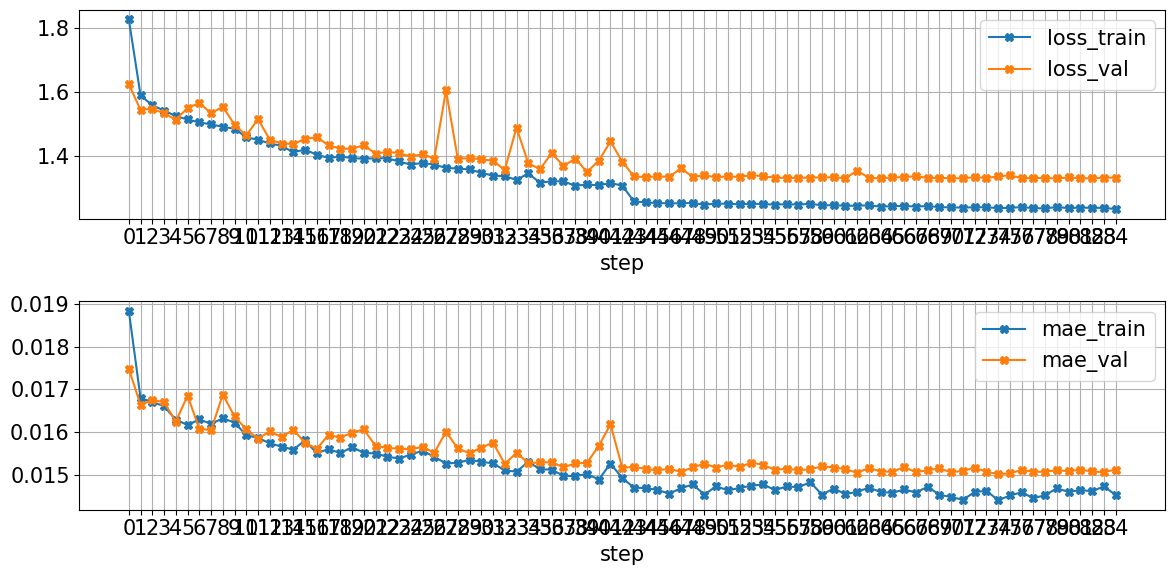

In [ ]:
model = Net().to(device)  # Create model instance
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.004)
criterion = nn.MSELoss().to(device) # Loss function

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=40)

# lambda1 = lambda epoch: 0.65 ** epoch
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, lr_lambda=lambda1)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

pp = train(model, criterion, optimizer, num_epochs=85)

# pp = train(model, criterion, optimizer, num_epochs=25)

In [ ]:
# Хороший вариант с результатом 0.
# model = Net().to(device)  # Create model instance
# model.train()
# optimizer = optim.Adam(model.parameters(), lr=0.004)
# criterion = nn.MSELoss().to(device) # Loss function

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=40)

# pp = train(model, criterion, optimizer, num_epochs=85)

## Сохранение весов модели

In [ ]:
# direct_out_model='drive/MyDrive/data_sphere/'
# torch.save(model.state_dict(), direct_out_model+'model_weights_5_q1q2_norm_.pth')

# Разделение событий по массам, полученное с помощью нейронной сети

In [ ]:
# again no gradients needed
with torch.no_grad():
    pred_save=[]
    out=[]
    for data in test_dataloader:
        video,images, labels = data
        video,images, labels=video.to(device),images.to(device), labels.to(device)
        batch_size_prov=len(labels)
        outputs = model(video,images,batch_size_prov)
        np_batch_out=torch.flatten(outputs).tolist()
        out.extend(np_batch_out)

out=np.array(out)

color3=['red','green','blue']
m_name=['p','N','Fe']

df_pred=pd.DataFrame({'pred':out,'y':y_test.reshape(-1)})

df_pred['m_name']=df_y['m_name']

df_pred

,pred,y,m_name
0,2.361225,1.386944,He
1,1.901479,3.467734,S
2,3.313459,2.639557,N
3,1.866682,1.386944,He
4,0.813110,2.639557,N
...,...,...,...
13061,2.261002,2.639557,N
13062,0.829248,0.001000,p
13063,2.677858,3.467734,S
13064,2.600153,2.639557,N


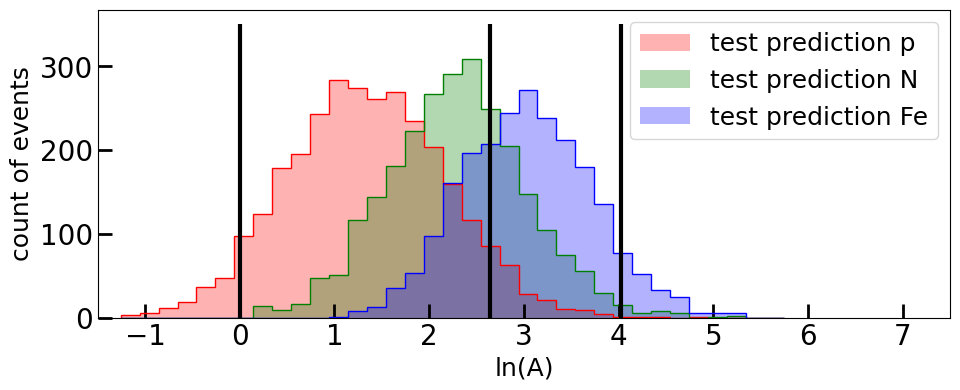

In [ ]:
direct_out_fig='drive/MyDrive/data_sphere/'
fig = plt.figure(figsize=(11,4))
bins=np.arange(0.6,4.2,0.05)
bins_mass=np.arange(df_pred['pred'].min(),df_pred['pred'].max(),0.2)
for i in range(3):
    plt.hist(df_pred['pred'][df_pred['m_name']==m_name[i]],bins=bins_mass,label='test prediction '+m_name[i],color=color3[i],alpha=0.3)
    plt.hist(df_pred['pred'][df_pred['m_name']==m_name[i]], histtype='step', bins=bins_mass,color=color3[i])
m_pNFe=[ln_m[0],ln_m[2],ln_m[4]]
plt.vlines(m_pNFe,0,350, linewidth=3,color='black')
plt.xlim(-1.5,7.5)
plt.legend(loc='upper right',fontsize=18)
plt.ylabel('count of events',fontsize=18)
plt.xlabel('ln(A)',fontsize=18)

plt.savefig(direct_out_fig+'separation_pNFe_with_norm_05.png',bbox_inches='tight')

## Поиск ошибки разделения событий

In [ ]:
p1=df_pred['pred'][df_pred['m_name']=='p']
N1=df_pred['pred'][df_pred['m_name']=='N']
Fe1=df_pred['pred'][df_pred['m_name']=='Fe']
df=np.array([np.array(p1), np.array(N1),np.array(Fe1)])

In [ ]:
N=50
pn_max_mi,nf_max_mi=100000,100000

cri=df
#-------------------------------p-N-----------------------------------------------
bpn_min=cri[0].mean()
bpn_max=cri[1].mean()
Nn=(bpn_max-bpn_min)/N

for bpn in np.arange(bpn_min,bpn_max,Nn):
    pn_p=np.count_nonzero(cri[0]>bpn)/float(len(df[0]))
    pn_n=np.count_nonzero(cri[1]<bpn)/float(len(df[1]))

    pn_max=max(pn_p,pn_n)

    if pn_max<pn_max_mi:
        pn_max_mi=pn_max
        pn_border_max=bpn
        er_pn_max=[round(pn_p,2),round(pn_n,2)]
        cr=cri
#--------------------------------N-Fe-----------------------------------------

bnf_min=cri[1].mean()
bnf_max=cri[2].mean()
Nf=(bnf_max-bnf_min)/N

for bnf in np.arange(bnf_min,bnf_max,Nf):      #Сразу считаю ошибки.
    nf_n=np.count_nonzero(cri[1]>bnf)/float(len(df[1]))
    nf_f=np.count_nonzero(cri[2]<bnf)/float(len(df[2]))

    nf_max=max(nf_n,nf_f)
    if nf_max<nf_max_mi:
        nf_max_mi=nf_max
        nf_border_max=bnf
        er_nf_max=[round(nf_n,2),round(nf_f,2)]

            #-----------------------------
print('Ошибка разделения событий протон-азот = ', round(pn_max_mi,2))
print('Ошибка разделения событий азот-железо = ', round(nf_max_mi,2))

Ошибка разделения событий протон-азот =  0.26
Ошибка разделения событий азот-железо =  0.29


Ошибка разделения событий протон-азот =  0.25

Ошибка разделения событий азот-железо =  0.27

# Для загруженной модели

In [ ]:
from ast import Pass
drive.mount('/content/drive')
direct_out_model='drive/MyDrive/data_sphere/'
model_load=Net().to(device)
model_load.load_state_dict(torch.load(direct_out_model+'model_weights_5_q1q2.pth'))
model_load.eval()

Mounted at /content/drive


Net(
  (conv1): Conv3d(1, 32, kernel_size=(2, 1, 1), stride=(4, 1, 1))
  (conv2): Conv3d(32, 16, kernel_size=(2, 1, 1), stride=(4, 1, 1))
  (conv3): Conv3d(16, 8, kernel_size=(3, 1, 1), stride=(1, 1, 1))
  (fc1): Linear(in_features=1210, out_features=484, bias=True)
  (fc2): Linear(in_features=484, out_features=1, bias=True)
)

## Загрузка дополнительных ядер

In [ ]:
# from ast import Pass
# drive.mount('/content/drive')
direct_q1='drive/MyDrive/data_sphere/data_to_NN_q1_900_10PeV_10-20/'

data_direct=[direct_q1+'glob_array_Be_q1.npy',direct_q1+'glob_array_C_q1.npy',direct_q1+'glob_array_Na_q1.npy',direct_q1+'glob_array_Ca_q1.npy' ]
map_direct=[direct_q1+'map2_Be_q1.npy',direct_q1+'map2_C_q1.npy',direct_q1+'map2_Na_q1.npy',direct_q1+'map2_Ca_q1.npy' ]

border=1200   # граница числа фотонов, если их в сумме зарегистрировалось меньше в одном событии, то такое событие не рассматривается.
data_all,data_2D,data_y=[],[],[]
# target_num=[0,1,1,0,1,1]
target_num=[0,1,2,3]

m_dop=[9,12, 22.98,40.08]
ln_m_dop=np.log(m_dop)
target_mass=[ln_m_dop[0],ln_m_dop[1],ln_m_dop[2],ln_m_dop[3]]
for i in range(4):

    particle_data=np.load( data_direct[i])
    particle_data=particle_data.reshape(6000,1,50,11,11)

    # Обрезаем данные
    bool_mask=[sum(particle_data[i])<border for i in range(6000)]
    particle_data=particle_data[~np.array(bool_mask)]
    # print(particle_data.min() ,particle_data.max())

    map2D=np.load( map_direct[i])
    map2D=map2D.reshape(6000,2,11,11)
    map2D=map2D[~np.array(bool_mask)]
    # print(map2D.min(),map2D.max())

    data_all.append(particle_data)
    data_2D.append(map2D)
    # data_y.append([target_num[i]]*particle_data.shape[0])    # В качетсве y целые числа, 0, 1, 2
    data_y.append([target_mass[i]]*particle_data.shape[0])

    print(particle_data.shape)


if len(data_all)==4:
    data_video=np.concatenate([data_all[0],data_all[1],data_all[2],data_all[3]])
    data_map = np.concatenate([data_2D[0],data_2D[1],data_2D[2],data_2D[3]])
    data_y=np.concatenate([data_y[0],data_y[1],data_y[2],data_y[3]])
    print('data video = ',data_video.shape,',  data map = ',data_map.shape,',  data y = ',data_y.shape)

data_video=(data_video-data_video.min())/(data_video.max()-data_video.min())   # Нормализция данных по кол-ву фотонов в ФЭУ в видео

(3874, 1, 50, 11, 11)
(3788, 1, 50, 11, 11)
(3579, 1, 50, 11, 11)
(3304, 1, 50, 11, 11)
data video =  (14545, 1, 50, 11, 11) ,  data map =  (14545, 2, 11, 11) ,  data y =  (14545,)


In [ ]:
# Стандартизация карт
m=(data_map[:,0]-data_map[:,0].mean())/data_map[:,0].std()  # Стандартизация числа фотонов
t=(data_map[:,1]-data_map[:,1].mean())/data_map[:,1].std()  # Стандартизация времени
a=np.array(list(zip(m,t)))
a.shape

(14545, 2, 11, 11)

In [ ]:
# Стандартизация видеоряда
vid=data_video.reshape(data_video.shape[0],50,11,11)
v=(vid-vid.mean())/vid.std()
v.shape

(14545, 50, 11, 11)

In [ ]:
X= v
X = X.reshape(X.shape[0], 1, 50, 11, 11)
print( 'X shape = ', X.shape)

y_test=data_y.reshape(data_y.shape[0],1)
print( 'y shape = ', y_test.shape)

X_test=np.array(list(zip(X,a)))

print(X_test.shape)
print(X_test[0,0].shape)
print(X_test[0,1].shape)

X shape =  (14545, 1, 50, 11, 11)
y shape =  (14545, 1)
(14545, 2)
(1, 50, 11, 11)
(2, 11, 11)


In [ ]:
df_y=pd.DataFrame({'y':y_test.reshape(-1)})

mass_value =ln_m_dop

df_y['m_name']=0
df_y['m_name'][df_y['y']==mass_value[0]]='Be'
df_y['m_name'][df_y['y']==mass_value[1]]='C'
df_y['m_name'][df_y['y']==mass_value[2]]='Na'
df_y['m_name'][df_y['y']==mass_value[3]]='Ca'
df_y

,y,m_name
0,2.197225,Be
1,2.197225,Be
2,2.197225,Be
3,2.197225,Be
4,2.197225,Be
...,...,...
14540,3.690877,Ca
14541,3.690877,Ca
14542,3.690877,Ca
14543,3.690877,Ca


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X = X[:,0]
        self.map=X[:,1]
        self.y=y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        video = torch.tensor(np.float32(self.X[idx]))
        imgs = torch.tensor(np.float32(self.map[idx]))
        label=torch.tensor(np.float32(self.y[idx]))

        return video, imgs, label

batch_size=64

test_dataset=CustomDataset(X_test,y_test)
test_dataloader_dop = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# again no gradients needed
with torch.no_grad():
    pred_save=[]
    out=[]
    for data in test_dataloader_dop:
        video,images, labels = data
        video,images, labels=video.to(device),images.to(device), labels.to(device)
        batch_size_prov=len(labels)
        outputs = model_load(video,images,batch_size_prov)
        np_batch_out=torch.flatten(outputs).tolist()
        out.extend(np_batch_out)

out=np.array(out)
print(out.shape,y_test.shape)

color3=['blue','orange','red','green']
m_name=['Be','C','Na','Ca']

df_pred=pd.DataFrame({'pred':out,'y':y_test.reshape(-1)})

df_pred['m_name']=df_y['m_name']

df_pred

(14545,) (14545, 1)


,pred,y,m_name
0,3.298773,2.197225,Be
1,2.450405,2.197225,Be
2,2.562150,2.197225,Be
3,1.266614,2.197225,Be
4,3.411076,2.197225,Be
...,...,...,...
14540,1.506192,3.690877,Ca
14541,2.683864,3.690877,Ca
14542,2.613634,3.690877,Ca
14543,1.408713,3.690877,Ca


Text(0.5, 0, 'ln(A)')

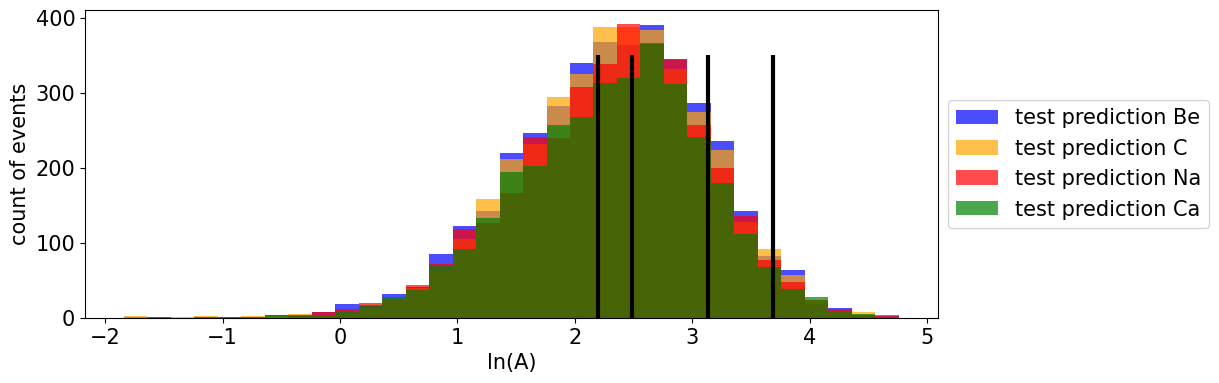

In [ ]:
fig = plt.figure(figsize=(11,4))
bins=np.arange(0.6,4.2,0.05)
bins_mass=np.arange(df_pred['pred'].min(),df_pred['pred'].max(),0.2)
for i in range(4):
    plt.hist(df_pred['pred'][df_pred['m_name']==m_name[i]],bins=bins_mass,label='test prediction '+m_name[i],color=color3[i],alpha=0.7)
plt.vlines(df_pred['y'].unique(),0,350, linewidth=3,color='black')

plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.ylabel('count of events')
plt.xlabel('ln(A)')

# plt.savefig(direct_out_fig+'separation_5_type.png',bbox_inches='tight')

In [ ]:
# Сохранение выхода нейронной сети
df_pred.to_csv(direct_out_model+'predictions_NN_lnA_add.csv')

 # Для тех же ядер загруженной модели

In [ ]:
direct_out_model='drive/MyDrive/data_sphere/'
model_load=Net().to(device)
model_load.load_state_dict(torch.load(direct_out_model+'model_weights_5_q1q2.pth'))
model_load.eval()

In [ ]:
# again no gradients needed
with torch.no_grad():
    pred_save=[]
    out=[]
    for data in test_dataloader:
        video,images, labels = data
        video,images, labels=video.to(device),images.to(device), labels.to(device)
        batch_size_prov=len(labels)
        outputs = model_load(video,images,batch_size_prov)
        np_batch_out=torch.flatten(outputs).tolist()
        out.extend(np_batch_out)

out=np.array(out)
print(out.shape,y_test.shape)

color3=['blue','orange','red','purple','green']
m_name=['p','He','N','S','Fe']

df_pred=pd.DataFrame({'pred':out,'y':y_test.reshape(-1)})

df_pred['m_name']=df_y['m_name']

df_pred

(14932,) (14932, 1)


,pred,y,m_name
0,1.777473,2.639557,N
1,1.946728,0.001000,p
2,1.963326,1.386944,He
3,3.365410,4.022580,Fe
4,1.717453,0.001000,p
...,...,...,...
14927,3.147259,3.467734,S
14928,1.534293,0.001000,p
14929,3.089865,3.467734,S
14930,2.474803,3.467734,S


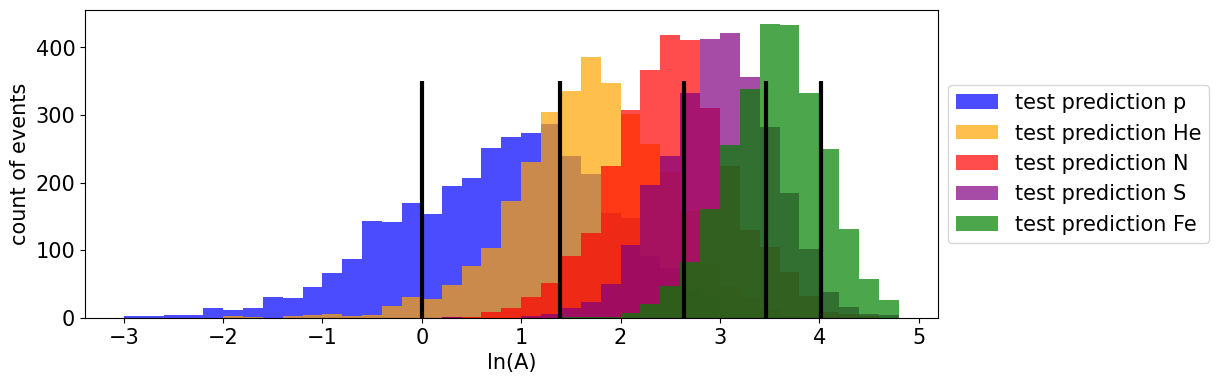

In [ ]:
fig = plt.figure(figsize=(11,4))
bins=np.arange(0.6,4.2,0.05)
bins_mass=np.arange(df_pred['pred'].min(),df_pred['pred'].max(),0.2)
for i in range(5):
    plt.hist(df_pred['pred'][df_pred['m_name']==m_name[i]],bins=bins_mass,label='test prediction '+m_name[i],color=color3[i],alpha=0.7)
plt.vlines(df_pred['y'].unique(),0,350, linewidth=3,color='black')

plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.ylabel('count of events')
plt.xlabel('ln(A)')

# plt.savefig(direct_out_fig+'separation_5_type.png',bbox_inches='tight')

In [ ]:
direct_out_model

'drive/MyDrive/data_sphere/'

In [ ]:
# Сохранение выхода нейронной сети
df_pred.to_csv(direct_out_model+'predictions_NN_lnA_norm.csv')

## Поиск ошибки разделения событий

In [ ]:
p1=df_pred['pred'][df_pred['m_name']=='p']
N1=df_pred['pred'][df_pred['m_name']=='N']
Fe1=df_pred['pred'][df_pred['m_name']=='Fe']
df=np.array([np.array(p1), np.array(N1),np.array(Fe1)])
df.shape

(3,)

In [ ]:
N=50
pn_max_mi,nf_max_mi=100000,100000

cri=df
#-------------------------------p-N-----------------------------------------------
bpn_min=cri[0].mean()
bpn_max=cri[1].mean()
Nn=(bpn_max-bpn_min)/N

for bpn in np.arange(bpn_min,bpn_max,Nn):
    pn_p=np.count_nonzero(cri[0]>bpn)/float(len(df[0]))
    pn_n=np.count_nonzero(cri[1]<bpn)/float(len(df[1]))

    pn_max=max(pn_p,pn_n)

    if pn_max<pn_max_mi:
        pn_max_mi=pn_max
        pn_border_max=bpn
        er_pn_max=[round(pn_p,2),round(pn_n,2)]
        cr=cri
#--------------------------------N-Fe-----------------------------------------

bnf_min=cri[1].mean()
bnf_max=cri[2].mean()
Nf=(bnf_max-bnf_min)/N

for bnf in np.arange(bnf_min,bnf_max,Nf):      #Сразу считаю ошибки.
    nf_n=np.count_nonzero(cri[1]>bnf)/float(len(df[1]))
    nf_f=np.count_nonzero(cri[2]<bnf)/float(len(df[2]))

    nf_max=max(nf_n,nf_f)

    if nf_max<nf_max_mi:
        nf_max_mi=nf_max
        nf_border_max=bnf
        er_nf_max=[round(nf_n,2),round(nf_f,2)]

            #-----------------------------
print('Ошибка разделения событий протон-азот = ', round(pn_max_mi,2))
print('Ошибка разделения событий азот-железо = ', round(nf_max_mi,2))

Ошибка разделения событий протон-азот =  0.15
Ошибка разделения событий азот-железо =  0.17
